<a href="https://colab.research.google.com/github/LeeJeongWoon-Workout/Deep_Learning_Pytorch/blob/main/Otto_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libray**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

Data PreProcessing

In [134]:
train_pd=pd.read_csv('/content/train.csv')
test_pd=pd.read_csv('/content/test.csv')
test_label=pd.read_csv('/content/sampleSubmission.csv')

train_pd=train_pd.drop(['id'],axis=1)
test_pd=test_pd.drop(['id'],axis=1)
drop=['id','Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']
test_label=test_label.drop(drop,axis=1)
test_pd=pd.concat([test_pd,test_label],axis=1)


to_normalize=['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7',
       'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13',
       'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19',
       'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25',
       'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31',
       'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36', 'feat_37',
       'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42', 'feat_43',
       'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49',
       'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55',
       'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60', 'feat_61',
       'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66', 'feat_67',
       'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72', 'feat_73',
       'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78', 'feat_79',
       'feat_80', 'feat_81', 'feat_82', 'feat_83', 'feat_84', 'feat_85',
       'feat_86', 'feat_87', 'feat_88', 'feat_89', 'feat_90', 'feat_91',
       'feat_92', 'feat_93']
for each in to_normalize:
    mean, std= train_pd[each].mean(), train_pd[each].std()
    train_pd.loc[:, each]=(train_pd[each]-mean)/std
for each in to_normalize:
    mean, std= test_pd[each].mean(), test_pd[each].std()
    test_pd.loc[:, each]=(test_pd[each]-mean)/std

dummies=pd.get_dummies(train_pd['target'],prefix='target',drop_first=False)
train_pd=pd.concat([train_pd,dummies],axis=1)
train_pd=train_pd.drop(['target'],axis=1)

columns_list=['target_Class_2', 'target_Class_3',
       'target_Class_4', 'target_Class_5', 'target_Class_6', 'target_Class_7',
       'target_Class_8', 'target_Class_9']

for i in columns_list:
  test_pd[i]=0

Define Dataset

In [143]:
class set_up_data(Dataset):
    def __init__(self, filename):
        data_matrix=filename.values
        data_matrix=torch.from_numpy(data_matrix)  #converting tensor to numpy for matrix operations
        self.data=data_matrix[:,0:92+1]              #columns 2-14 are the data 
        self.data=self.data.float()
        self.target=data_matrix[:,92+1:1000]               #column 1 is the true output
        
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        #return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        return self.data[index], self.target[index]

train_data=set_up_data(train_pd)
train_loader = DataLoader(train_data,batch_size=256,shuffle=True)

test_data=set_up_data(test_pd)
test_loader=DataLoader(test_data,batch_size=256)

Define Model

In [173]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(93, 64)
        self.linear2 = torch.nn.Linear(64, 64)
        self.linear3 = torch.nn.Linear(64, 32)
        self.linear4 = torch.nn.Linear(32, 9)
        self.linearlinear=nn.Sequential(
            self.linear1,
            nn.ELU(),
            self.linear2,
            nn.ELU(),
            self.linear3,
            nn.ELU(),
            self.linear4,

        )
 
    def forward(self, x):
        x=self.linearlinear(x)
        return x

In [174]:
model     = Net()
model=model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(reduction='mean').cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model Training

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


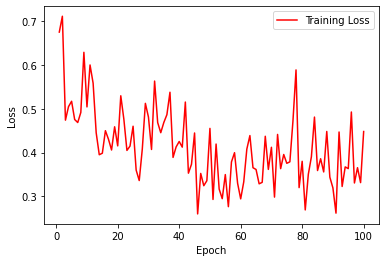

Training loss: 0.3543980931940158


In [175]:
import tqdm

epochs=100
loss_data=[]
for e in tqdm.trange(epochs):
    running_loss = 0#get images
    for info, labels in train_loader:
        info=info.to(device)
        labels=labels.to(device)
        #Flatten images
        #images=images.view(images.shape[0], -1)
        dummy_labels=labels.float()
        #info=info.reshape(info.shape[0],)
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #Forward pass
        output=model(info)
        

        #Calculate the loss
        loss=loss_fn(output,dummy_labels)
        
        
        
        #backward propagation
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    


     ## TODO: Implement the validation pass and print out the validation accuracy
    else:
        #print(f"Training loss: {running_loss/len(train_loader)}") 
        loss_data.append(loss)
        #print('bias',model.linearlinear[0].bias)
        #print('weight',model.linearlinear[0].weight)
        #print("output",output)
        #print("labels",dummy_labels)
        #print('shape',info.shape)
#print("output",output)   

epoch_count = range(1, epochs + 1)

plt.plot(epoch_count, loss_data, 'r')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

print(f"Training loss: {running_loss/len(train_loader)}") 

Model Evaluation

In [176]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data, target in test_loader : 
        data, target = data.to(device), target.to(device)       
        output = model(data)
        target=target.argmax(dim=1)
        pred = output.argmax(dim=1)
        correct += pred.eq(target.view_as(pred)).sum().item()

print('Test Accuracy: ',100*correct/len(test_loader.dataset))

Test Accuracy:  2.4894713509919097
